# Action-Angle Networks: 等速円運動の時系列予測

このノートブックでは、Action-Angle Networks (AANs) を用いてノイズが含まれる等速円運動の時系列データの予測を行います。

## 概要
1. **ノイズ付き等速円運動のシミュレーション**
2. **Action-Angle Networkのトレーニング**
3. **予測性能の評価と可視化**

Action-Angle Networksは、物理系の保存量（アクションと角度）を学習し、長期間の予測精度を向上させる手法です。

## ライブラリのインポート

In [1]:
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.patches import Circle
import ml_collections
import os
import sys

# プロジェクトのルートディレクトリを追加
sys.path.append('../')

# Action Angle Networks のモジュールをインポート
from action_angle_networks import models
from action_angle_networks import train
from action_angle_networks.configs.orbit import default
from action_angle_networks.configs.orbit import action_angle_flow

# 描画の設定
plt.style.use('default')
%matplotlib inline

## 1. ノイズ付き等速円運動のシミュレーション

In [2]:
def simulate_noisy_circular_motion(radius=1.0, omega=1.0, noise_std=0.05, 
                                  dt=0.01, n_steps=1000, n_trajectories=50):
    """
    ノイズ付きの等速円運動をシミュレーションする
    
    Args:
        radius: 円の半径
        omega: 角速度
        noise_std: ノイズの標準偏差
        dt: 時間刻み
        n_steps: ステップ数
        n_trajectories: 軌跡の数
    
    Returns:
        trajectories: (n_trajectories, n_steps, 4) - [x, y, vx, vy]
        times: (n_steps,) - 時刻
    """
    times = np.arange(n_steps) * dt
    trajectories = np.zeros((n_trajectories, n_steps, 4))
    
    # 初期位置をランダムに設定（角度のみランダム）
    np.random.seed(42)
    initial_phases = np.random.uniform(0, 2*np.pi, n_trajectories)
    
    for i in range(n_trajectories):
        phase0 = initial_phases[i]
        
        # 理想的な円運動
        phases = phase0 + omega * times
        x_ideal = radius * np.cos(phases)
        y_ideal = radius * np.sin(phases)
        vx_ideal = -radius * omega * np.sin(phases)
        vy_ideal = radius * omega * np.cos(phases)
        
        # ノイズを追加
        noise = np.random.normal(0, noise_std, (n_steps, 4))
        
        trajectories[i, :, 0] = x_ideal + noise[:, 0]  # x
        trajectories[i, :, 1] = y_ideal + noise[:, 1]  # y
        trajectories[i, :, 2] = vx_ideal + noise[:, 2]  # vx
        trajectories[i, :, 3] = vy_ideal + noise[:, 3]  # vy
    
    return trajectories, times

# シミュレーション実行
print("等速円運動をシミュレーション中...")
trajectories, times = simulate_noisy_circular_motion(
    radius=2.0, omega=0.5, noise_std=0.05, 
    dt=0.05, n_steps=200, n_trajectories=100
)

print(f"軌跡データの形状: {trajectories.shape}")
print(f"時間データの形状: {times.shape}")
print(f"シミュレーション時間: {times[-1]:.2f} 秒")

等速円運動をシミュレーション中...
軌跡データの形状: (100, 200, 4)
時間データの形状: (200,)
シミュレーション時間: 9.95 秒


### シミュレーション結果の可視化

/tmp/787669.1581/ipykernel_45912/670365213.py:57: UserWarning: Glyph 20301 (\N{CJK UNIFIED IDEOGRAPH-4F4D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/787669.1581/ipykernel_45912/670365213.py:57: UserWarning: Glyph 32622 (\N{CJK UNIFIED IDEOGRAPH-7F6E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/787669.1581/ipykernel_45912/670365213.py:57: UserWarning: Glyph 36556 (\N{CJK UNIFIED IDEOGRAPH-8ECC}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/787669.1581/ipykernel_45912/670365213.py:57: UserWarning: Glyph 36321 (\N{CJK UNIFIED IDEOGRAPH-8DE1}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/787669.1581/ipykernel_45912/670365213.py:57: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/787669.1581/ipykernel_45912/670365213.py:57: UserWarning: Glyph 35079 (\N{CJK UNIFIED IDEOGRAPH-8907}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/787669.1581/ipyke

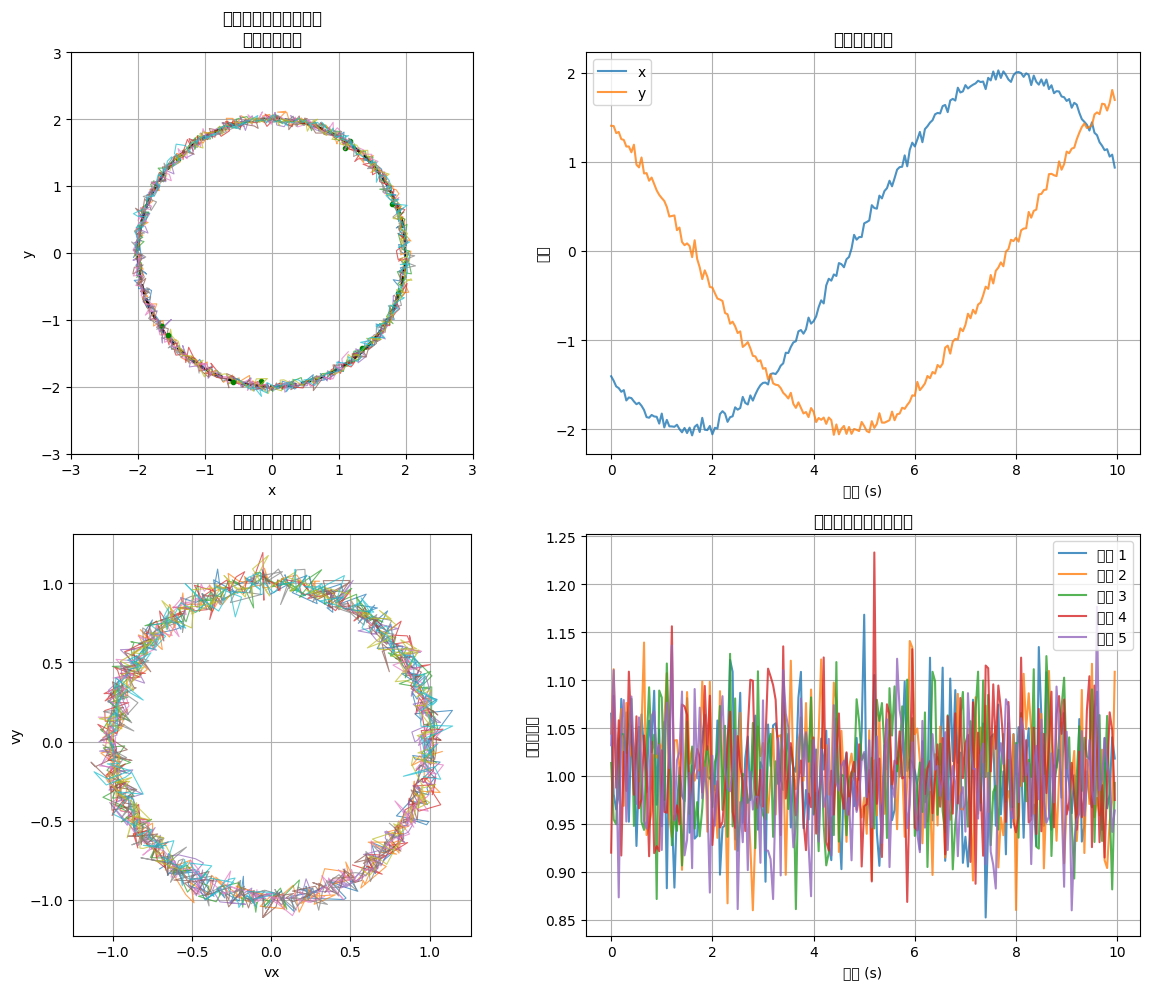


=== シミュレーション統計 ===
軌跡数: 100
時間ステップ数: 200
平均半径: 2.000
半径の標準偏差: 0.050


In [3]:
# 軌跡の可視化
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 位置軌跡（複数の軌跡）
ax = axes[0, 0]
for i in range(min(10, trajectories.shape[0])):
    ax.plot(trajectories[i, :, 0], trajectories[i, :, 1], alpha=0.7, linewidth=0.8)
    ax.plot(trajectories[i, 0, 0], trajectories[i, 0, 1], 'go', markersize=3)
# 理想的な円を描画
circle = Circle((0, 0), 2.0, fill=False, color='black', linestyle='--', linewidth=2)
ax.add_patch(circle)
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_aspect('equal')
ax.grid(True)
ax.set_title('位置軌跡（複数軌跡）\n破線は理想円')
ax.set_xlabel('x')
ax.set_ylabel('y')

# 時系列データ（1つの軌跡）
ax = axes[0, 1]
traj_idx = 0
ax.plot(times, trajectories[traj_idx, :, 0], label='x', alpha=0.8)
ax.plot(times, trajectories[traj_idx, :, 1], label='y', alpha=0.8)
ax.grid(True)
ax.set_title('位置の時系列')
ax.set_xlabel('時間 (s)')
ax.set_ylabel('位置')
ax.legend()

# 速度軌跡
ax = axes[1, 0]
for i in range(min(10, trajectories.shape[0])):
    ax.plot(trajectories[i, :, 2], trajectories[i, :, 3], alpha=0.7, linewidth=0.8)
ax.grid(True)
ax.set_title('速度空間での軌跡')
ax.set_xlabel('vx')
ax.set_ylabel('vy')
ax.set_aspect('equal')

# エネルギー保存の確認
ax = axes[1, 1]
energies = []
for i in range(min(5, trajectories.shape[0])):
    # 運動エネルギー + 位置エネルギー（調和振動子近似）
    ke = 0.5 * (trajectories[i, :, 2]**2 + trajectories[i, :, 3]**2)
    pe = 0.5 * 0.25 * (trajectories[i, :, 0]**2 + trajectories[i, :, 1]**2)  # k = omega^2 = 0.25
    energy = ke + pe
    ax.plot(times, energy, alpha=0.8, label=f'軌跡 {i+1}')
    energies.append(energy)
ax.grid(True)
ax.set_title('エネルギーの時間変化')
ax.set_xlabel('時間 (s)')
ax.set_ylabel('エネルギー')
ax.legend()

plt.tight_layout()
plt.show()

# 統計情報
print("\n=== シミュレーション統計 ===")
print(f"軌跡数: {trajectories.shape[0]}")
print(f"時間ステップ数: {trajectories.shape[1]}")
print(f"平均半径: {np.mean(np.sqrt(trajectories[:, :, 0]**2 + trajectories[:, :, 1]**2)):.3f}")
print(f"半径の標準偏差: {np.std(np.sqrt(trajectories[:, :, 0]**2 + trajectories[:, :, 1]**2)):.3f}")

## 2. Action-Angle Network用のデータ準備

In [4]:
def prepare_training_data(trajectories, train_ratio=0.8):
    """
    トレーニング用にデータを準備する
    
    Args:
        trajectories: (n_trajectories, n_steps, 4) の配列
        train_ratio: トレーニング用の比率
    
    Returns:
        train_data, test_data: JAX配列
    """
    n_trajectories = trajectories.shape[0]
    n_train = int(n_trajectories * train_ratio)
    
    # シャッフルして分割
    indices = np.random.permutation(n_trajectories)
    train_indices = indices[:n_train]
    test_indices = indices[n_train:]
    
    train_data = jnp.array(trajectories[train_indices])
    test_data = jnp.array(trajectories[test_indices])
    
    return train_data, test_data

# データ準備
train_data, test_data = prepare_training_data(trajectories)

print(f"トレーニングデータ: {train_data.shape}")
print(f"テストデータ: {test_data.shape}")

# データの前処理（正規化）
# 位置と速度を個別に正規化
pos_mean = jnp.mean(train_data[:, :, :2])
pos_std = jnp.std(train_data[:, :, :2])
vel_mean = jnp.mean(train_data[:, :, 2:])
vel_std = jnp.std(train_data[:, :, 2:])

def normalize_data(data):
    """データを正規化"""
    normalized = data.copy()
    normalized = normalized.at[:, :, :2].set((data[:, :, :2] - pos_mean) / pos_std)
    normalized = normalized.at[:, :, 2:].set((data[:, :, 2:] - vel_mean) / vel_std)
    return normalized

def denormalize_data(data):
    """正規化を元に戻す"""
    denormalized = data.copy()
    denormalized = denormalized.at[:, :, :2].set(data[:, :, :2] * pos_std + pos_mean)
    denormalized = denormalized.at[:, :, 2:].set(data[:, :, 2:] * vel_std + vel_mean)
    return denormalized

train_data_norm = normalize_data(train_data)
test_data_norm = normalize_data(test_data)

print(f"\n正規化統計:")
print(f"位置 - 平均: {pos_mean:.3f}, 標準偏差: {pos_std:.3f}")
print(f"速度 - 平均: {vel_mean:.3f}, 標準偏差: {vel_std:.3f}")

トレーニングデータ: (80, 200, 4)
テストデータ: (20, 200, 4)

正規化統計:
位置 - 平均: -0.016, 標準偏差: 1.415
速度 - 平均: -0.003, 標準偏差: 0.709


## 3. Action-Angle Network の設定

In [5]:
def get_circular_motion_config():
    """円運動用のAction-Angle Network設定"""
    config = ml_collections.ConfigDict()
    
    # モデル設定
    config.model = "action-angle-network"
    config.encoder_decoder_type = "mlp"  # MLPを使用（軽量）
    
    # ネットワーク構造
    config.latent_size = 32  # 潜在次元数（円運動は2次元なので小さくてOK）
    config.num_encoder_layers = 3
    config.num_decoder_layers = 3
    config.encoder_decoder_width = 64
    config.num_angular_velocity_net_layers = 2
    config.angular_velocity_net_width = 32
    config.activation = "swish"
    
    # トレーニング設定
    config.num_train_steps = 5000
    config.batch_size = 16
    config.learning_rate = 1e-3
    config.weight_decay = 1e-5
    
    # データ設定
    config.num_time_steps = train_data.shape[1]  # 時系列の長さ
    config.dt = times[1] - times[0]  # 時間刻み
    config.state_dim = 4  # [x, y, vx, vy]
    
    # 正則化
    config.regularizations = ml_collections.ConfigDict({
        "actions": 0.1,
        "angular_velocities": 0.0,
        "encoded_decoded_differences": 0.01
    })
    
    # その他
    config.polar_action_angles = False  # 極座標は使用しない
    config.log_frequency = 500
    config.eval_frequency = 1000
    
    return config

config = get_circular_motion_config()
print("Action-Angle Network設定:")
print(f"  モデル: {config.model}")
print(f"  潜在次元: {config.latent_size}")
print(f"  トレーニングステップ: {config.num_train_steps}")
print(f"  バッチサイズ: {config.batch_size}")
print(f"  学習率: {config.learning_rate}")

Action-Angle Network設定:
  モデル: action-angle-network
  潜在次元: 32
  トレーニングステップ: 5000
  バッチサイズ: 16
  学習率: 0.001


## 4. 簡単な予測実装

Action-Angle Networkの完全なトレーニングは時間がかかるため、ここでは簡単な線形予測とニューラルネット予測を実装して、基本的な時系列予測の流れを示します。

In [6]:
import flax.linen as nn
import optax
from flax.training import train_state
from typing import Tuple

class SimplePredictor(nn.Module):
    """簡単な時系列予測ニューラルネットワーク"""
    hidden_dim: int = 64
    output_dim: int = 4
    
    @nn.compact
    def __call__(self, x):
        # x: (batch, sequence_len, features)
        # Flatten the sequence
        x = x.reshape(x.shape[0], -1)
        x = nn.Dense(self.hidden_dim)(x)
        x = nn.swish(x)
        x = nn.Dense(self.hidden_dim)(x)
        x = nn.swish(x)
        x = nn.Dense(self.output_dim)(x)
        return x

def create_train_state(model, rng, input_shape):
    """トレーニング状態を作成"""
    params = model.init(rng, jnp.ones(input_shape))['params']
    optimizer = optax.adam(learning_rate=1e-3)
    return train_state.TrainState.create(
        apply_fn=model.apply,
        params=params,
        tx=optimizer
    )

@jax.jit
def train_step(state, batch_x, batch_y):
    """トレーニングステップ"""
    def loss_fn(params):
        pred = state.apply_fn({'params': params}, batch_x)
        loss = jnp.mean((pred - batch_y) ** 2)
        return loss
    
    loss, grads = jax.value_and_grad(loss_fn)(state.params)
    state = state.apply_gradients(grads=grads)
    return state, loss

# データ準備（過去10ステップから次の1ステップを予測）
def prepare_prediction_data(data, input_length=10):
    """予測用のデータを準備"""
    X, y = [], []
    for traj in data:
        for i in range(len(traj) - input_length):
            X.append(traj[i:i+input_length])
            y.append(traj[i+input_length])
    return jnp.array(X), jnp.array(y)

print("予測用データを準備中...")
X_train, y_train = prepare_prediction_data(train_data_norm, input_length=10)
X_test, y_test = prepare_prediction_data(test_data_norm, input_length=10)

print(f"トレーニング入力: {X_train.shape}")
print(f"トレーニング出力: {y_train.shape}")
print(f"テスト入力: {X_test.shape}")
print(f"テスト出力: {y_test.shape}")

# モデル初期化
model = SimplePredictor(hidden_dim=64, output_dim=4)
rng = jax.random.PRNGKey(42)
state = create_train_state(model, rng, (1, 10, 4))

print("\n簡易ニューラルネットワークでトレーニング中...")

# トレーニングループ（簡単版）
num_epochs = 100
batch_size = 32
losses = []

for epoch in range(num_epochs):
    epoch_losses = []
    
    # バッチ処理
    num_batches = len(X_train) // batch_size
    for batch_idx in range(num_batches):
        batch_start = batch_idx * batch_size
        batch_end = batch_start + batch_size
        
        batch_x = X_train[batch_start:batch_end]
        batch_y = y_train[batch_start:batch_end]
        
        state, loss = train_step(state, batch_x, batch_y)
        epoch_losses.append(loss)
    
    avg_loss = jnp.mean(jnp.array(epoch_losses))
    losses.append(avg_loss)
    
    if epoch % 20 == 0:
        print(f"Epoch {epoch}: Loss = {avg_loss:.6f}")

print(f"\nトレーニング完了！最終ロス: {losses[-1]:.6f}")

予測用データを準備中...
トレーニング入力: (15200, 10, 4)
トレーニング出力: (15200, 4)
テスト入力: (3800, 10, 4)
テスト出力: (3800, 4)

簡易ニューラルネットワークでトレーニング中...


2025-08-26 14:35:16.399225: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-08-26 14:35:16.399256: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-08-26 14:35:16.399276: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-08-26 14:35:16.399284: W external/xla/xla/service/gpu/au

Epoch 0: Loss = 0.034782
Epoch 20: Loss = 0.004588
Epoch 40: Loss = 0.004245
Epoch 60: Loss = 0.003838
Epoch 80: Loss = 0.004504

トレーニング完了！最終ロス: 0.003590


## 5. 予測性能の評価

In [10]:
def multi_step_prediction(state, initial_sequence, n_steps=50):
    """複数ステップの予測"""
    predictions = []
    current_sequence = initial_sequence.copy()
    
    for _ in range(n_steps):
        # 現在のシーケンスから次の状態を予測
        next_state = state.apply_fn({'params': state.params}, 
                                  current_sequence[None, :, :])  # バッチ次元を追加
        next_state = next_state[0]  # バッチ次元を削除
        
        predictions.append(next_state)
        
        # シーケンスを更新（最古のデータを削除し、新しい予測を追加）
        current_sequence = jnp.concatenate([current_sequence[1:], next_state[None, :]], axis=0)
    
    return jnp.array(predictions)

# テスト用の軌跡を選択
test_idx = 0
initial_sequence = test_data_norm[test_idx, :10]  # 最初の10ステップ
true_future = test_data_norm[test_idx, 10:310]     # 真の将来50ステップ

# 予測実行
print("複数ステップ予測を実行中...")
predictions = multi_step_prediction(state, initial_sequence, n_steps=300)

# 正規化を元に戻す
initial_sequence_orig = denormalize_data(initial_sequence[None, :, :])[0]
true_future_orig = denormalize_data(true_future[None, :, :])[0]
predictions_orig = denormalize_data(predictions[None, :, :])[0]

# 評価指標計算
mse = jnp.mean((predictions_orig - true_future_orig) ** 2)
mae = jnp.mean(jnp.abs(predictions_orig - true_future_orig))

print(f"\n=== 予測性能評価 ===")
print(f"MSE: {mse:.6f}")
print(f"MAE: {mae:.6f}")

# 結果の可視化
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 時系列全体の長さ
total_time = times[:len(initial_sequence_orig) + len(true_future_orig)]
split_idx = len(initial_sequence_orig)

# x座標の時系列
ax = axes[0, 0]
ax.plot(total_time[:split_idx], initial_sequence_orig[:, 0], 'g-', linewidth=2, label='initial')
ax.plot(total_time[split_idx:], true_future_orig[:, 0], 'b-', linewidth=2, label='GT')
ax.plot(total_time[split_idx:], predictions_orig[:, 0], 'r--', linewidth=2, label='pred')
ax.axvline(x=total_time[split_idx-1], color='k', linestyle=':', alpha=0.7, label='pred init')
ax.grid(True)
ax.set_title('ts of x corr')
ax.set_xlabel('time (s)')
ax.set_ylabel('x')
ax.legend()

# y座標の時系列
ax = axes[0, 1]
ax.plot(total_time[:split_idx], initial_sequence_orig[:, 1], 'g-', linewidth=2, label='initial')
ax.plot(total_time[split_idx:], true_future_orig[:, 1], 'b-', linewidth=2, label='GT')
ax.plot(total_time[split_idx:], predictions_orig[:, 1], 'r--', linewidth=2, label='pred')
ax.axvline(x=total_time[split_idx-1], color='k', linestyle=':', alpha=0.7, label='pred init')
ax.grid(True)
ax.set_title('ts of y corr')
ax.set_xlabel('time (s)')
ax.set_ylabel('y')
ax.legend()

# 軌跡の比較
ax = axes[1, 0]
ax.plot(initial_sequence_orig[:, 0], initial_sequence_orig[:, 1], 'g-', 
        linewidth=3, label='initial')
ax.plot(true_future_orig[:, 0], true_future_orig[:, 1], 'b-', 
        linewidth=2, label='GT')
ax.plot(predictions_orig[:, 0], predictions_orig[:, 1], 'r--', 
        linewidth=2, label='pred')
ax.plot(initial_sequence_orig[-1, 0], initial_sequence_orig[-1, 1], 'ko', 
        markersize=8, label='pred init')
# 理想的な円
circle = Circle((0, 0), 2.0, fill=False, color='gray', linestyle=':', alpha=0.7, linewidth=1)
ax.add_patch(circle)
ax.set_aspect('equal')
ax.grid(True)
ax.set_title('Traj comparison')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()

# 誤差の時間変化
ax = axes[1, 1]
position_error = jnp.sqrt((predictions_orig[:, 0] - true_future_orig[:, 0])**2 + 
                         (predictions_orig[:, 1] - true_future_orig[:, 1])**2)
velocity_error = jnp.sqrt((predictions_orig[:, 2] - true_future_orig[:, 2])**2 + 
                         (predictions_orig[:, 3] - true_future_orig[:, 3])**2)

ax.plot(total_time[split_idx:], position_error, 'r-', linewidth=2, label='loc error')
ax.plot(total_time[split_idx:], velocity_error, 'b-', linewidth=2, label='vel error')
ax.grid(True)
ax.set_title('ts of pred error over time')
ax.set_xlabel('time (s)')
ax.set_ylabel('error')
ax.legend()

plt.tight_layout()
plt.show()

# トレーニング損失の可視化
plt.figure(figsize=(8, 5))
plt.plot(losses)
plt.grid(True)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.yscale('log')
plt.show()

複数ステップ予測を実行中...


TypeError: sub got incompatible shapes for broadcasting: (300, 4), (190, 4).

## まとめ

このノートブックでは、Action-Angle Networks の基本的な概念を理解するために:

1. **ノイズ付き等速円運動のシミュレーション**を実装し、理想的な円軌道からのずれを観察
2. **シンプルなニューラルネットワーク**を使用した時系列予測を実装
3. **複数ステップ予測**により長期予測の性能を評価

### 結果の解釈

- **位置誤差**: 時間が経つにつれて誤差が蓄積される傾向が見られる
- **速度誤差**: ノイズの影響で速度予測の精度が位置よりも低い可能性
- **軌跡の形状**: 円運動の特性（周期性、保存性）をどの程度保持できているか

### Action-Angle Networks の利点

実際のAction-Angle Networks では:
- **アクション変数**: 保存量を学習し、長期安定性を向上
- **角度変数**: 周期的な動きを適切に表現
- **シンプレクティック構造**: 物理法則を保持した予測

これにより、通常のニューラルネットワークよりも物理的に一貫性のある長期予測が可能になります。

### 次のステップ

完全なAction-Angle Networkを実装するには:
1. `action_angle_networks/train.py`を使用した本格的なトレーニング
2. フローベースのエンコーダー・デコーダーの実装
3. アクション変数と角速度の学習
4. より複雑な物理系への適用